<a href="https://colab.research.google.com/github/ERerGB/Apprentice/blob/main/Sign_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')



https://drive.google.com/file/d/1TCY5P0Ifm4tX-eX3du1jC472-8eBZPLb/view?usp=sharing

https://drive.google.com/file/d/1TCY5P0Ifm4tX-eX3du1jC472-8eBZPLb/view?usp=sharing

In [ ]:
# !gdown '1TCY5P0Ifm4tX-eX3du1jC472-8eBZPLb' --output Training_Data_traffic_Signs.zip

In [ ]:
# !unzip '/content/gdrive/MyDrive/Colab_Notebooks/Training_Data _raffic_Signs.zip'

!unzip '/content/Training_Data_traffic_Signs.zip'

In [ ]:
#!python3 setup.py install ipython

# %pip install IPython
# from IPython import display

In [ ]:
# from IPython import display

# import pytorch
import torch
# from PIL import Image
import torchvision.transforms as transforms
import pandas as pd
from torchvision.io import read_image

import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torch.nn import functional as F

from IPython import display

# import my_utils as mu

In [ ]:
# Transforming image to tensor

def transform_pic_to_pixel(img_path,sharp,size): 

    image= read_image(img_path)

    transform = transforms.Compose([
        # transforms.PILToTensor(),
        transforms.CenterCrop(sharp),
        transforms.Resize((size,size))
    ])

    img_tensor = transform(image).float()
    
    return img_tensor

In [ ]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset():
    def __init__(self, annotations_file, img_dir, #transform=None, target_transform=None#
                 ):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        # self.transform = transform
        # self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        sharp = min((self.img_labels.iloc[idx, 0],self.img_labels.iloc[idx, 1]))
        img_path = os.path.join(self.img_dir,self.img_labels.iloc[idx, -1])
        # if self.trasform:
        # img = self.transform(img_path)
        
        # if self.transform:
        image = transform_pic_to_pixel(img_path,sharp,25)

        label = int(self.img_labels.iloc[idx, -2])
        
        # if self.target_transform:
        #     label = self.target_transform(label)
        return image, label

In [ ]:
dataset = CustomImageDataset('/content/Training Data Traffic Signs/Train.csv',
                '/content/Training Data Traffic Signs'
                )

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, #num_workers=5
                              )

Feature batch shape: torch.Size([128, 3, 25, 25])
Labels batch shape: torch.Size([128])


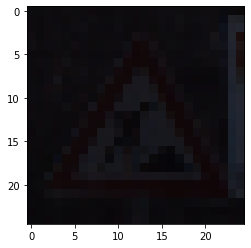

Label: 25


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze().int()
label = train_labels[0]
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [ ]:
class Residual_block(nn.Module):  
    def __init__(self, input_channels, output_channels, use_1x1conv=False, strides=1):
        super(Residual_block, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(output_channels, output_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, output_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
            
        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x))) 
        out = self.bn2(self.conv2(out))
        if self.conv3:
            x = self.conv3(x)
        out = out + x
        return F.relu(out)

class Resnet_macro_block(nn.Module):
    def __init__(self, input_channels, output_channels, num_residuals, first_block=False):
        super(Resnet_macro_block, self).__init__()
        self.num_residuals = num_residuals
        for i in range(num_residuals):
            if i == 0 and not first_block:
                self.add_module('conv{0}'.format(i), 
                                Residual_block(input_channels, output_channels, use_1x1conv=True, strides=2))
            else:
                self.add_module('conv{0}'.format(i), 
                                Residual_block(output_channels, output_channels))
    def forward(self, x):
        out = x
        for i in range(self.num_residuals):
            out = self._modules['conv{0}'.format(i)](out)
        return out 
#%%
class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.stem = nn.Sequential(nn.Conv2d(3, 64, kernel_size=5, stride=1, padding=1),
                   nn.BatchNorm2d(64), nn.ReLU())
        self.b2 = Resnet_macro_block(64, 64, 2)
        self.b3 = Resnet_macro_block(64, 128, 2)
        self.b4 = Resnet_macro_block(128, 256, 2)
        self.b5 = Resnet_macro_block(256, 512, 2)
        self.last = nn.Sequential(nn.AdaptiveMaxPool2d((1,1)), nn.Flatten(), nn.Linear(512, 43))
        
    def forward(self, x):
        out = self.stem(x)
        out = self.b2(out)
        out = self.b3(out)
        out = self.b4(out)
        out = self.b5(out)
        out = self.last(out)
        return out

In [ ]:
resnet18 = Resnet18().to(device)
# batch_size = 256
# train_iter, test_iter = mu.load_data_fashion_mnist(batch_size, resize=32)
# train_iter2 = iter(train_iter)
# x = next(train_iter2)
# print(x[0].size())
# y_hat = resnet18(x[0])

In [ ]:
lr, num_epochs = 0.025, 20
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet18.parameters(), lr=lr)

In [ ]:
# def weight_reset(m):
#     if isinstance(m, nn.Module):
#         m.reset_parameters()

In [ ]:
def trainf(net, train_iter, #test_iter,
            loss, num_epochs, optimizer, device):
    """Train and evaluate a model with CPU or GPU."""
    # net.apply(weight_reset)
    net.to(device)
    # animator = mu.d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
    #                         legend=['train loss', 'train acc'])
    
    display.set_matplotlib_formats('svg')
    fig, axs = plt.subplots(1,1,figsize=(7, 2.5))

    Y_train_loss = []
    Y_train_acc = []
    X_PLOT = []

    # patience = 300
    # divergence = 0


    # train_loss=0
    # timer = mu.d2l.Timer()
    lowest_loss = 10
    cnt = 0 

    for epoch in range(num_epochs):
        # metric = [0.0] * 3#mu.d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        
        
        for i, (X, y) in enumerate(train_iter):
            
            # if cnt>=patience:
            #   break
            
            # timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X).to(device)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # with 
            torch.no_grad()
                # metric.add(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0])
                # for num, (a,b) in enumerate(zip(metric,(l*X.shape[0], mu.d2l.accuracy(y_hat, y), X.shape[0]))):
                #   metric[num] = a+float(b)
            # timer.stop()
            train_loss  = float(l) # metric[0]/metric[2]
            # train_acc  = metric[1]/metric[2]

            train_acc = float(torch.sum((np.argmax(y_hat.type(y.dtype).to('cpu'),axis=1)) == y.to('cpu')))/X.shape[0]

            # print(train_loss, train_acc)

            # if lowest_loss - train_loss <= divergence:
            #   cnt+=1
            # else:
            #   lowest_loss = train_loss
            #   cnt = 0

            # Visualized
            if (i+1) % 20 == 0:
                # animator.add(epoch + i/len(train_iter),
                #               (train_loss, train_acc))
                # axs.cla()

                X_PLOT.append(epoch + i/len(train_iter))
                Y_train_loss.append(train_loss)
                Y_train_acc.append(train_acc)

                axs.plot(X_PLOT,Y_train_loss,'g-')
                axs.plot(X_PLOT,Y_train_acc,'m--')

                axs.set_xlim([0, num_epochs])
                axs.legend(['train loss', 'train acc'])
                display.display(fig)
                display.clear_output(wait=True)
        # test_acc = mu.evaluate_accuracy_gpu(net, test_iter)
        # animator.add(epoch+1, (None, None))


        # if cnt>=patience:
        #   break

    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}'
    #,patience remain{patience-cnt}/{patience}
          # f'test acc {test_acc:.3f}
    )
    # print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          # f'on {str(device)}')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #choose device: cpu or gpu
print('Using device:', device)
if torch.cuda.is_available(): print(torch.cuda.get_device_name(0)) # print the type of the chosen gpu
trainf(resnet18, train_dataloader, 
      #  test_iter,
       loss, num_epochs, optimizer, device)